In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
import torch

#import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [37]:
METHOD = False
USE_GPU = False
LINUX = True
WEATHER = True
#Use linux file paths


if USE_GPU:
    #torch.zeros(1).cuda()
    #torch.cuda.is_available()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cpu


In [38]:
if WEATHER:
    icouk_data_weather = '..\\Data\\cloudtest.csv'
    data = pd.read_csv(icouk_data_weather)
    data=data.drop(['Cloud Level','Distance'], axis = 1)
else:
    data_file = '..\\Data\\moon_sighting_data.csv'
    if LINUX:
        data_file = '../Data/moon_sighting_data.csv'

    data = pd.read_csv(data_file)

print(f"Loaded {data.shape[0]} rows")

data = data.drop(["Index","q","W","q'","W'",'Visibility', 'Source'], axis = 1)

if METHOD: # method and methods columns, will be changed
    data = data.drop('Seen', axis = 1) # replaced by method column
    ptype = [r"Not_seen", r"Seen_eye", r"Seen_binoculars", r"Seen_telescope", r"Seen_ccd"] # CHANGE THIS
else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1)
    # List of label options
    ptype = [r"Seen", r"Not_seen"]

print(f"Selected {data.shape[0]} rows")

variable_list =  data.columns.tolist()
variable_list.remove('Seen')

data['Sunset'] -= data['Date'] # reducing magnitude of date datapoints
data['Moonset'] -= data['Date']
data['Date'] -= 2400000
data['Date'] *= 1/10000

Loaded 319 rows
Selected 316 rows


In [39]:
data.head(10)

,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,Seen,Cloud cover
0,5.925823,52.48142,-1.89983,0.935,-0.01219,0.01525,39.51667,2.28332,241.76737,-3.34868,252.16322,0.0026,0.98474,11.81934,5.63200,10.39585,0.01060,56.29433,Not_seen,6
1,5.925823,53.75000,-2.48333,0.935,-0.01203,0.01503,38.96667,2.14031,240.97890,-3.23162,251.52301,0.0026,0.98474,11.82980,5.37193,10.54410,0.01062,56.30026,Not_seen,3
2,5.925823,53.58333,-2.43333,0.935,-0.01205,0.01506,39.05000,2.15988,241.08536,-3.24731,251.61090,0.0026,0.98474,11.82930,5.40719,10.52554,0.01062,56.29942,Not_seen,3
3,5.925823,53.58333,-2.43333,0.935,-0.01205,0.01506,39.05000,2.15988,241.08536,-3.24731,251.61090,0.0026,0.98474,11.82930,5.40719,10.52554,0.01062,56.29942,Not_seen,3
4,5.925823,51.62127,0.30556,0.931,-0.01218,0.01524,39.48333,2.34983,242.27205,-3.40259,252.52998,0.0026,0.98474,11.75662,5.75242,10.25793,0.01049,56.29437,Not_seen,6
5,5.925823,51.45523,-2.59665,0.939,-0.01240,0.01550,40.16667,2.41319,242.37016,-3.45872,252.66280,0.0026,0.98474,11.84551,5.87191,10.29264,0.01065,56.28682,Not_seen,1
6,5.925823,51.38333,-0.10000,0.932,-0.01225,0.01532,39.70000,2.38350,242.40850,-3.43106,252.64678,0.0026,0.98474,11.76999,5.81456,10.23828,0.01051,56.29208,Not_seen,6
7,5.925823,51.50853,-0.12574,0.932,-0.01223,0.01529,39.63333,2.36973,242.33670,-3.41905,252.58979,0.0026,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,Not_seen,6
8,5.925823,51.50853,-0.12574,0.932,-0.01223,0.01529,39.63333,2.36973,242.33670,-3.41905,252.58979,0.0026,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,Not_seen,6
9,5.925823,51.50853,-0.12574,0.932,-0.01223,0.01529,39.63333,2.36973,242.33670,-3.41905,252.58979,0.0026,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,Not_seen,6


In [40]:
y = np.array(data['Seen'])
X = np.array(data[variable_list])

y[y == 'Seen'] = int(1)
y[y == 'Not_seen'] = int(0)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, y,test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [41]:
# Define the neural network model
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer with 1 neuron for binary classification
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Sigmoid activation for binary classification, now softmax
        return x
    
input_size = len(variable_list)  # Number of input variables
hidden_size = 32  # Number of neurons in the hidden layers #32
output_size = 2 # for binary output
model = CustomNN(input_size, hidden_size, output_size).to(device)

num_epochs = 300
batch_size = 60

# Define binary cross-entropy loss and Adam optimizer
criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay = 0.01) #0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.9) # i dont know what this is

MY METHOD

In [42]:
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train.astype("float64")).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test.astype("float64")).float()

ANNA METHOD

In [43]:
#data prep for anna code
trainset = TensorDataset(X_train_tensor, Y_train_tensor)
testset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [44]:
def train(model, trainloader, optimiser, device):

    train_loss = 0.0

    model.train()
    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        optimiser.zero_grad()

        #p_y = F.softmax(model(data), dim=1)
        #loss = model.loss(p_y, labels)
        p_y = model(data)
        loss_criterion = nn.CrossEntropyLoss()
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(device)
        loss = loss_criterion(p_y, labels)
            
        train_loss += loss.item() * data.size(0)

        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

def test(model, testloader, device):

    correct = 0
    #total = 0
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            #p_y = F.softmax(model(data), dim=1)
            #loss = model.loss(p_y, labels)
            p_y = model(data)
            loss_criterion = nn.CrossEntropyLoss()
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            loss = loss_criterion(p_y, labels)
                
            test_loss += loss.item() * data.size(0)

            preds = p_y.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()

        test_loss /= len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)

    return test_loss, accuracy

In [45]:
# #anna method
result_arr=[]
_bestacc = 0.
quiet = True
result_arr = np.zeros((num_epochs,4))

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    train_loss = train(model, train_loader, optimizer, device)
    test_loss, accuracy = test(model, test_loader, device)
        
    scheduler.step(test_loss)

    # check early stopping criteria:
    #if early_stopping and accuracy>_bestacc:
    #    _bestacc = accuracy
    #    torch.save(model.state_dict(), modfile)
    #    best_acc = accuracy
    #    best_epoch = epoch
        
    # create output row:
    results = [epoch, train_loss, test_loss, accuracy]
    
    result_arr[epoch] = results
    if not quiet:
        print('Epoch: {}, Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(epoch, test_loss, accuracy))
        print('Current learning rate is: {}'.format(optimizer.param_groups[0]['lr']))
        
print("Final validation error: ",100.*(1 - accuracy))
#if early_stopping:
#    print("Best validation error: ",100.*(1 - best_acc)," @ epoch: "+str(best_epoch))r    result_arr

Final validation error:  4.1666666666666625


In [46]:
#print(result_arr)

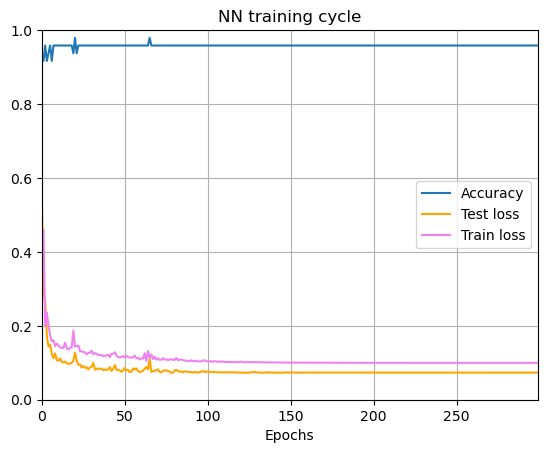

In [47]:
#print(result_arr)
#plt.fig()
plt.plot(result_arr[:,0],result_arr[:,3],linestyle='-', label='Accuracy')
plt.plot(result_arr[:,0],result_arr[:,2],linestyle='-', c='orange',label='Test loss')
plt.plot(result_arr[:,0],result_arr[:,1],linestyle='-', c='violet',label='Train loss')
plt.ylim(0,1)
plt.xlim(0,num_epochs-1)
plt.title('NN training cycle')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

In [48]:
print(r'Final accuracy is {}'.format(result_arr[-1,3]))

Final accuracy is 0.9583333333333334


In [49]:
X_test_tensor = torch.Tensor(X_test).to(device)
predictions = model(X_test_tensor)

In [51]:
#model.evaluate(X_test, Y_test)[1]